# MARATONA BEHIND THE CODE 2020

## DESAFIO 7: TNT

## Testes com modelo XGBoost
<br>

![Image](https://abir.org.br/abir/wp-content/uploads/2019/04/tnt-1024x685.png)

# Parte 01. Importando as bibliotecas

In [1]:
# Pacotes padrao
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Pacote do sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pacote ML
from xgboost import XGBClassifier
import xgboost as xgb

# Pacote para balanceamento dos dados
from imblearn.over_sampling import SMOTE

# Pacote para hyperparametros
import optuna
import functools

# Desativando warnings no jupyter
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Parte 02. Carregando o dataset de treino

In [2]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
treino = pd.read_csv(r'train_17015.csv')
print('Quantidade de registros e colunas: ',treino.shape)
treino.head()

Quantidade de registros e colunas:  (17015, 15)


,Tempo,Estacao,LAT,LONG,Movimentacao,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET,row
0,2019-12-30,Fradique Coutinho,-23.5661,-46.6841,35386,24,45,61,42,19,22,15,9,NORMAL,10800
1,2018-01-08,Luz,-23.5365,-46.6332,124806,15,10,10,29,10,25,14,13,NORMAL,10808
2,2018-04-17,Luz,-23.5365,-46.6332,125215,53,1,55,18,18,6,37,8,REABASTECER,10907
3,2018-07-18,Luz,-23.5365,-46.6332,126476,36,5,57,38,15,43,43,18,REABASTECER,10998
4,2018-08-28,Luz,-23.5365,-46.6332,125917,79,10,8,37,32,30,18,15,NORMAL,11038


In [3]:
# Visualizando o tipo dos dados
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17015 entries, 0 to 17014
Data columns (total 15 columns):
Tempo           16921 non-null object
Estacao         17015 non-null object
LAT             17015 non-null float64
LONG            17015 non-null float64
Movimentacao    17015 non-null int64
Original_473    17015 non-null int64
Original_269    17015 non-null int64
Zero            17015 non-null int64
Maca_Verde      17015 non-null int64
Tangerina       17015 non-null int64
Citrus          17015 non-null int64
Acai_Guarana    17015 non-null int64
Pessego         17015 non-null int64
TARGET          17015 non-null object
row             17015 non-null int64
dtypes: float64(2), int64(10), object(3)
memory usage: 1.9+ MB


,TARGET,%
NORMAL,11517,67.687
REABASTECER,5498,32.313


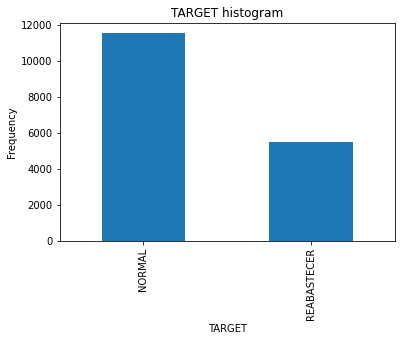

In [4]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

# Parte 03. Feature Engineering

In [5]:
# Removendo colunas que não serão utilizadas no treinamento
treino = treino.drop(['Tempo','Estacao','Movimentacao','LAT','LONG', 'row'], axis = 1)

# Converte colunas para numerico
treino = treino.apply(pd.to_numeric, errors='ignore')

# Visualizando os primeiros registros
treino.head()

,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET
0,24,45,61,42,19,22,15,9,NORMAL
1,15,10,10,29,10,25,14,13,NORMAL
2,53,1,55,18,18,6,37,8,REABASTECER
3,36,5,57,38,15,43,43,18,REABASTECER
4,79,10,8,37,32,30,18,15,NORMAL


# Parte 04. Modelagem Preditiva
> - Nesta fase estarei construindo os modelos preditivos
> - Vou utilizar o modelo XGB para treinamento

In [6]:
# Definindo alguns parametros
SEED  = 42

In [7]:
# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

# Selecionando feature target
y = treino['TARGET']

# Transformando target em tipo numerico
y = y.astype("category").cat.codes

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Split dos dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)

### Sem Balanceamento dos dados

Acurácia: 75.79%
Sensibilidade : 0.6972727272727273
Especificidade : 0.7867998263135041


              precision    recall  f1-score   support

           0       0.84      0.79      0.81      2303
           1       0.61      0.70      0.65      1100

    accuracy                           0.76      3403
   macro avg       0.73      0.74      0.73      3403
weighted avg       0.77      0.76      0.76      3403



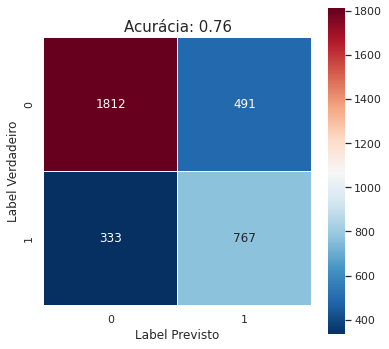

In [8]:
# Criando o modelo
modelo_xgb_v1 = XGBClassifier()

# Treinando o modelo
modelo_xgb_v1.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v1.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v1 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v1 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v1), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Com Balanceamento dos dados

In [9]:
# Aplicando a funcao SMOTE
sm = SMOTE(random_state=0)
X_treino_bal, y_treino_bal = sm.fit_sample(X_treino, y_treino)

Acurácia: 76.26%
Sensibilidade : 0.7263636363636363
Especificidade : 0.7798523664785063


              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2303
           1       0.61      0.73      0.66      1100

    accuracy                           0.76      3403
   macro avg       0.73      0.75      0.74      3403
weighted avg       0.78      0.76      0.77      3403



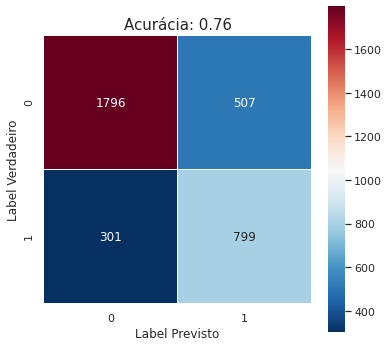

In [10]:
# Criando o modelo
modelo_xgb_v2 = XGBClassifier()

# Treinando o modelo
modelo_xgb_v2.fit(X_treino_bal, y_treino_bal)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v2.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v2 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v2 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v2), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Identificando os melhores Hyperparametros

In [11]:
def objective(trial):
    # Selecionando features para treinamento
    X = treino.drop(['TARGET'], axis = 1)

    # Selecionando feature target
    y = treino['TARGET']

    # Transformando target em tipo numerico
    y = y.astype("category").cat.codes

    # Padronizando os dados (0 para a média, 1 para o desvio padrão)
    X = StandardScaler().fit_transform(X)

    # Split dos dados
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)    

    dtrain = xgb.DMatrix(X_treino, label=y_treino)
    dvalid = xgb.DMatrix(X_teste, label=y_teste)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_teste, pred_labels)
    return accuracy

In [12]:
study_v2 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=15), direction="maximize")
study_v2.optimize(objective, n_trials=100)
print(study_v2.best_trial)

[0]	validation-auc:0.81693
[1]	validation-auc:0.81555
[2]	validation-auc:0.81208
[3]	validation-auc:0.81686
[4]	validation-auc:0.81663
[5]	validation-auc:0.81491
[6]	validation-auc:0.81781
[7]	validation-auc:0.81447
[8]	validation-auc:0.81572
[9]	validation-auc:0.81401


[I 2020-09-10 16:40:56,878] Finished trial#0 with value: 0.7716720540699383 with parameters: {'booster': 'dart', 'lambda': 8.559835117041465e-05, 'alpha': 0.0004312506771536429, 'max_depth': 7, 'eta': 1.0833452991236941e-07, 'gamma': 3.2353950249549464e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.19071378727082175, 'skip_drop': 4.950876424999997e-06}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.72272
[1]	validation-auc:0.72272
[2]	validation-auc:0.72272
[3]	validation-auc:0.72272
[4]	validation-auc:0.72272
[5]	validation-auc:0.72272
[6]	validation-auc:0.72272
[7]	validation-auc:0.72272
[8]	validation-auc:0.72272
[9]	validation-auc:0.72272


[I 2020-09-10 16:40:57,089] Finished trial#1 with value: 0.7508081104907435 with parameters: {'booster': 'dart', 'lambda': 2.5806853508658626e-05, 'alpha': 0.0001441422977491492, 'max_depth': 4, 'eta': 0.0002976295325946508, 'gamma': 0.0015943775300971948, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.1984363327612886e-05, 'skip_drop': 0.0346357826837619}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-10 16:40:57,343] Finished trial#2 with value: 0.6767558037026153 with parameters: {'booster': 'gblinear', 'lambda': 0.14015417091645196, 'alpha': 0.21368867314365403}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-10 16:40:57,522] Finished trial#3 with value: 0.6767558037026153 with parameters: {'booster': 'gblinear', 'lambda': 1.340754343565088e-05, 'alpha': 0.4202558924643398}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.75054
[1]	validation-auc:0.75078
[2]	validation-auc:0.75078
[3]	validation-auc:0.75078
[4]	validation-auc:0.75078
[5]	validation-auc:0.75078
[6]	validation-auc:0.75078
[7]	validation-auc:0.75078
[8]	validation-auc:0.75078
[9]	validation-auc:0.75078


[I 2020-09-10 16:40:57,712] Finished trial#4 with value: 0.7508081104907435 with parameters: {'booster': 'gbtree', 'lambda': 5.392437908816718e-08, 'alpha': 0.15868505350310597, 'max_depth': 5, 'eta': 0.001153848822449224, 'gamma': 1.4311641866999205e-06, 'grow_policy': 'depthwise'}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.75113
[1]	validation-auc:0.79270
[2]	validation-auc:0.82506
[3]	validation-auc:0.84828
[4]	validation-auc:0.85099
[5]	validation-auc:0.85302
[6]	validation-auc:0.85138
[7]	validation-auc:0.85261
[8]	validation-auc:0.85143
[9]	validation-auc:0.85463


[I 2020-09-10 16:40:57,901] Finished trial#5 with value: 0.7355274757566853 with parameters: {'booster': 'gbtree', 'lambda': 0.0016552921293333598, 'alpha': 1.378875471190433e-08, 'max_depth': 5, 'eta': 0.09687133610435336, 'gamma': 0.02725721746649777, 'grow_policy': 'depthwise'}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-10 16:40:58,065] Finished trial#6 with value: 0.6767558037026153 with parameters: {'booster': 'gblinear', 'lambda': 0.9800763728372618, 'alpha': 0.28560782123261796}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.72278
[1]	validation-auc:0.72293
[2]	validation-auc:0.72293
[3]	validation-auc:0.72257
[4]	validation-auc:0.72257
[5]	validation-auc:0.72293
[6]	validation-auc:0.72293
[7]	validation-auc:0.72293
[8]	validation-auc:0.72275
[9]	validation-auc:0.72275


[I 2020-09-10 16:40:58,332] Finished trial#7 with value: 0.7508081104907435 with parameters: {'booster': 'dart', 'lambda': 0.11964882180012995, 'alpha': 4.1330303406587653e-07, 'max_depth': 4, 'eta': 2.7696560150921315e-06, 'gamma': 0.003288625881682833, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0002803834425624202, 'skip_drop': 2.376621433757787e-07}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67648
[2]	validation-auc:0.67664
[3]	validation-auc:0.67674
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67690
[7]	validation-auc:0.67692
[8]	validation-auc:0.67694
[9]	validation-auc:0.67694


[I 2020-09-10 16:40:58,510] Finished trial#8 with value: 0.6738172200999119 with parameters: {'booster': 'gblinear', 'lambda': 2.163177753137953e-08, 'alpha': 4.810818031788745e-05}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.75152
[1]	validation-auc:0.79349
[2]	validation-auc:0.84996
[3]	validation-auc:0.84952
[4]	validation-auc:0.85027
[5]	validation-auc:0.85311
[6]	validation-auc:0.85092
[7]	validation-auc:0.85115
[8]	validation-auc:0.85021
[9]	validation-auc:0.85167


[I 2020-09-10 16:40:58,704] Finished trial#9 with value: 0.7264178665883044 with parameters: {'booster': 'dart', 'lambda': 0.1414911982311263, 'alpha': 0.1111963955345812, 'max_depth': 5, 'eta': 0.10509150974084544, 'gamma': 0.0037042096179132388, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.793113770214274e-07, 'skip_drop': 5.154896208521309e-06}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.75036
[1]	validation-auc:0.74965
[2]	validation-auc:0.75051
[3]	validation-auc:0.75040
[4]	validation-auc:0.75098
[5]	validation-auc:0.74959
[6]	validation-auc:0.74947
[7]	validation-auc:0.75051
[8]	validation-auc:0.75038
[9]	validation-auc:0.74945


[I 2020-09-10 16:40:58,897] Finished trial#10 with value: 0.7508081104907435 with parameters: {'booster': 'dart', 'lambda': 0.0010379007476967184, 'alpha': 0.00045771316258890734, 'max_depth': 5, 'eta': 1.6121098664944054e-07, 'gamma': 0.0003628094474541428, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.004787022823716284, 'skip_drop': 1.4464053502003001e-05}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.84302
[1]	validation-auc:0.84383
[2]	validation-auc:0.84106
[3]	validation-auc:0.84223
[4]	validation-auc:0.84072
[5]	validation-auc:0.84093
[6]	validation-auc:0.84236
[7]	validation-auc:0.84208
[8]	validation-auc:0.84193
[9]	validation-auc:0.84360


[I 2020-09-10 16:40:59,119] Finished trial#11 with value: 0.7699089039083162 with parameters: {'booster': 'dart', 'lambda': 5.484821742812336e-06, 'alpha': 0.00044159252973415236, 'max_depth': 9, 'eta': 0.10135863932816383, 'gamma': 5.199514908200365e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00018343271564934602, 'skip_drop': 4.911100651526778e-07}. Best is trial#0 with value: 0.7716720540699383.


[0]	validation-auc:0.83703
[1]	validation-auc:0.83656
[2]	validation-auc:0.83922
[3]	validation-auc:0.84255
[4]	validation-auc:0.83908
[5]	validation-auc:0.83807
[6]	validation-auc:0.83746
[7]	validation-auc:0.83746
[8]	validation-auc:0.84245
[9]	validation-auc:0.84251


[I 2020-09-10 16:40:59,344] Finished trial#12 with value: 0.7725536291507493 with parameters: {'booster': 'dart', 'lambda': 1.1190627642547482e-06, 'alpha': 0.002283230966290516, 'max_depth': 9, 'eta': 1.7682230862770616e-05, 'gamma': 1.5177863900177063e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00024234792999015183, 'skip_drop': 1.0540464083793202e-06}. Best is trial#12 with value: 0.7725536291507493.


[0]	validation-auc:0.78358
[1]	validation-auc:0.78358
[2]	validation-auc:0.78358
[3]	validation-auc:0.78358
[4]	validation-auc:0.78358
[5]	validation-auc:0.78358
[6]	validation-auc:0.78358
[7]	validation-auc:0.78359
[8]	validation-auc:0.78359
[9]	validation-auc:0.78352


[I 2020-09-10 16:40:59,545] Finished trial#13 with value: 0.7655010285042609 with parameters: {'booster': 'dart', 'lambda': 5.406231572403438e-07, 'alpha': 0.006111251830643226, 'max_depth': 6, 'eta': 3.347754366123561e-05, 'gamma': 6.852486392744687e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.8684977982074226e-05, 'skip_drop': 0.00014207524153574287}. Best is trial#12 with value: 0.7725536291507493.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-10 16:40:59,728] Finished trial#14 with value: 0.6767558037026153 with parameters: {'booster': 'dart', 'lambda': 0.000676605366913058, 'alpha': 0.005000108850021921, 'max_depth': 1, 'eta': 1.0904656618224025e-08, 'gamma': 2.076888874186783e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.4949527565702222e-07, 'skip_drop': 7.466650264611204e-08}. Best is trial#12 with value: 0.7725536291507493.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.51877
[4]	validation-auc:0.52636
[5]	validation-auc:0.53488
[6]	validation-auc:0.54536
[7]	validation-auc:0.84159
[8]	validation-auc:0.84006
[9]	validation-auc:0.83966


[I 2020-09-10 16:40:59,954] Finished trial#15 with value: 0.7034969144872172 with parameters: {'booster': 'dart', 'lambda': 1.0541288197048934e-06, 'alpha': 3.528328999802293e-06, 'max_depth': 9, 'eta': 1.1630946071304603e-08, 'gamma': 0.5618515722666361, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.03213271709985419, 'skip_drop': 5.733986089311109e-08}. Best is trial#12 with value: 0.7725536291507493.


[0]	validation-auc:0.81687
[1]	validation-auc:0.81498
[2]	validation-auc:0.81460
[3]	validation-auc:0.81577
[4]	validation-auc:0.81599
[5]	validation-auc:0.81477
[6]	validation-auc:0.81516
[7]	validation-auc:0.81588
[8]	validation-auc:0.81581
[9]	validation-auc:0.81554


[I 2020-09-10 16:41:00,204] Finished trial#16 with value: 0.7716720540699383 with parameters: {'booster': 'gbtree', 'lambda': 0.00018282839180526586, 'alpha': 0.0063537459216818585, 'max_depth': 7, 'eta': 4.5112127359742657e-07, 'gamma': 1.3887012183057962e-05, 'grow_policy': 'lossguide'}. Best is trial#12 with value: 0.7725536291507493.


[0]	validation-auc:0.84006
[1]	validation-auc:0.84018
[2]	validation-auc:0.84114
[3]	validation-auc:0.84044
[4]	validation-auc:0.84074
[5]	validation-auc:0.84078
[6]	validation-auc:0.84073
[7]	validation-auc:0.84083
[8]	validation-auc:0.84089
[9]	validation-auc:0.84092


[I 2020-09-10 16:41:00,445] Finished trial#17 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 2.1098498171378936e-07, 'alpha': 3.256098515962833e-05, 'max_depth': 8, 'eta': 1.3559823608123054e-05, 'gamma': 2.151293386723541e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.1218656658601914e-08, 'skip_drop': 0.0008798340095366322}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.83994
[1]	validation-auc:0.84006
[2]	validation-auc:0.84051
[3]	validation-auc:0.84045
[4]	validation-auc:0.84074
[5]	validation-auc:0.84078
[6]	validation-auc:0.84078
[7]	validation-auc:0.84086
[8]	validation-auc:0.84109
[9]	validation-auc:0.84101


[I 2020-09-10 16:41:00,670] Finished trial#18 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 1.5110840270011496e-07, 'alpha': 7.5673054646519205e-06, 'max_depth': 8, 'eta': 3.194581924926908e-05, 'gamma': 3.163015822526451e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.910585843541436e-08, 'skip_drop': 0.0020790472868095302}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84174
[2]	validation-auc:0.84187
[3]	validation-auc:0.84183
[4]	validation-auc:0.84220
[5]	validation-auc:0.84310
[6]	validation-auc:0.84222
[7]	validation-auc:0.84235
[8]	validation-auc:0.84366
[9]	validation-auc:0.84477


[I 2020-09-10 16:41:00,893] Finished trial#19 with value: 0.7807816632383191 with parameters: {'booster': 'dart', 'lambda': 2.023100791191863e-07, 'alpha': 4.753467970545042e-06, 'max_depth': 8, 'eta': 0.004261276612842197, 'gamma': 9.981418521650247e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.0741832688405314e-08, 'skip_drop': 0.006869298520762416}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.81393
[1]	validation-auc:0.81452
[2]	validation-auc:0.81493
[3]	validation-auc:0.81502
[4]	validation-auc:0.81561
[5]	validation-auc:0.81565
[6]	validation-auc:0.81556
[7]	validation-auc:0.81573
[8]	validation-auc:0.81558
[9]	validation-auc:0.81576


[I 2020-09-10 16:41:01,104] Finished trial#20 with value: 0.7716720540699383 with parameters: {'booster': 'gbtree', 'lambda': 1.0567514811078167e-08, 'alpha': 8.946941059201638e-08, 'max_depth': 7, 'eta': 2.777523176467946e-06, 'gamma': 6.317294891814271e-06, 'grow_policy': 'lossguide'}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84080
[2]	validation-auc:0.84188
[3]	validation-auc:0.84190
[4]	validation-auc:0.84358
[5]	validation-auc:0.84377
[6]	validation-auc:0.84384
[7]	validation-auc:0.84429
[8]	validation-auc:0.84479
[9]	validation-auc:0.84434


[I 2020-09-10 16:41:01,331] Finished trial#21 with value: 0.7801939465177784 with parameters: {'booster': 'dart', 'lambda': 1.3988534294721318e-07, 'alpha': 7.5925170243374305e-06, 'max_depth': 8, 'eta': 0.0046600095549513155, 'gamma': 2.7099257665037937e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.6438470698666973e-08, 'skip_drop': 0.0006763763648792373}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.57006
[1]	validation-auc:0.57006
[2]	validation-auc:0.57006
[3]	validation-auc:0.57006
[4]	validation-auc:0.57006
[5]	validation-auc:0.57006
[6]	validation-auc:0.57006
[7]	validation-auc:0.57006
[8]	validation-auc:0.57006
[9]	validation-auc:0.57006


[I 2020-09-10 16:41:01,526] Finished trial#22 with value: 0.7005583308845137 with parameters: {'booster': 'dart', 'lambda': 1.9438499883934615e-07, 'alpha': 5.541212637860917e-06, 'max_depth': 1, 'eta': 0.0001171304264646435, 'gamma': 0.0001053695528376015, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.467329903711252e-07, 'skip_drop': 0.49056003888730837}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.84019
[1]	validation-auc:0.84013
[2]	validation-auc:0.84062
[3]	validation-auc:0.84050
[4]	validation-auc:0.84084
[5]	validation-auc:0.84090
[6]	validation-auc:0.84083
[7]	validation-auc:0.84083
[8]	validation-auc:0.84090
[9]	validation-auc:0.84093


[I 2020-09-10 16:41:01,752] Finished trial#23 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 1.2687832117031414e-08, 'alpha': 7.445821512669046e-07, 'max_depth': 8, 'eta': 4.581732340616124e-06, 'gamma': 1.6555224320458996e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.163167763414822e-08, 'skip_drop': 0.0030604824904858097}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.78350
[1]	validation-auc:0.78348
[2]	validation-auc:0.78342
[3]	validation-auc:0.78343
[4]	validation-auc:0.78345
[5]	validation-auc:0.78345
[6]	validation-auc:0.78345
[7]	validation-auc:0.78345
[8]	validation-auc:0.78358
[9]	validation-auc:0.78358


[I 2020-09-10 16:41:01,965] Finished trial#24 with value: 0.7655010285042609 with parameters: {'booster': 'dart', 'lambda': 1.0289296497266428e-08, 'alpha': 5.906920662210022e-07, 'max_depth': 6, 'eta': 2.614125218135915e-06, 'gamma': 1.1695130751070596e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.3152778437875114e-06, 'skip_drop': 0.15578063283590796}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.84005
[1]	validation-auc:0.84009
[2]	validation-auc:0.84052
[3]	validation-auc:0.84054
[4]	validation-auc:0.84074
[5]	validation-auc:0.84079
[6]	validation-auc:0.84076
[7]	validation-auc:0.84083
[8]	validation-auc:0.84091
[9]	validation-auc:0.84094


[I 2020-09-10 16:41:02,193] Finished trial#25 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 4.758744462297856e-08, 'alpha': 2.7847945516206257e-05, 'max_depth': 8, 'eta': 1.1516340206284259e-05, 'gamma': 5.054134761779882e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2856326412249272e-08, 'skip_drop': 0.00014769417253001181}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.83825
[1]	validation-auc:0.84031
[2]	validation-auc:0.84021
[3]	validation-auc:0.84094
[4]	validation-auc:0.84099
[5]	validation-auc:0.84087
[6]	validation-auc:0.84067
[7]	validation-auc:0.84102
[8]	validation-auc:0.84104
[9]	validation-auc:0.84115


[I 2020-09-10 16:41:02,446] Finished trial#26 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 4.51282683818427e-08, 'alpha': 6.401075308756667e-07, 'max_depth': 8, 'eta': 6.859374698019338e-07, 'gamma': 3.996972782576762e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.4066331066130115e-07, 'skip_drop': 6.920200863427673e-05}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.83711
[1]	validation-auc:0.83745
[2]	validation-auc:0.83754
[3]	validation-auc:0.83721
[4]	validation-auc:0.83765
[5]	validation-auc:0.83773
[6]	validation-auc:0.83778
[7]	validation-auc:0.83752
[8]	validation-auc:0.83774
[9]	validation-auc:0.83757


[I 2020-09-10 16:41:02,681] Finished trial#27 with value: 0.7725536291507493 with parameters: {'booster': 'dart', 'lambda': 3.1588876806806343e-06, 'alpha': 1.3120128856180485e-08, 'max_depth': 9, 'eta': 5.221892916650718e-07, 'gamma': 2.3040947287729466e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.7060116071964833e-07, 'skip_drop': 0.031631228828430516}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81447
[2]	validation-auc:0.81482
[3]	validation-auc:0.81532
[4]	validation-auc:0.81514
[5]	validation-auc:0.81544
[6]	validation-auc:0.81544
[7]	validation-auc:0.81562
[8]	validation-auc:0.81626
[9]	validation-auc:0.81636


[I 2020-09-10 16:41:02,901] Finished trial#28 with value: 0.772259770790479 with parameters: {'booster': 'dart', 'lambda': 1.0252213013747062e-08, 'alpha': 1.0852381607046723e-07, 'max_depth': 7, 'eta': 6.973670351091922e-05, 'gamma': 1.0190231684311125e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.82458723576588e-06, 'skip_drop': 8.728416731515059e-05}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.50301
[1]	validation-auc:0.52090
[2]	validation-auc:0.78685
[3]	validation-auc:0.78648
[4]	validation-auc:0.78450
[5]	validation-auc:0.78527
[6]	validation-auc:0.78135
[7]	validation-auc:0.78009
[8]	validation-auc:0.78609
[9]	validation-auc:0.78777


[I 2020-09-10 16:41:03,114] Finished trial#29 with value: 0.7587422862180428 with parameters: {'booster': 'dart', 'lambda': 3.967670038243638e-08, 'alpha': 9.26427006081724e-07, 'max_depth': 6, 'eta': 4.907727300835319e-08, 'gamma': 1.960487255967381e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.064209083213033e-08, 'skip_drop': 0.00013207580219141345}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.83938
[1]	validation-auc:0.84017
[2]	validation-auc:0.84057
[3]	validation-auc:0.84047
[4]	validation-auc:0.84086
[5]	validation-auc:0.84081
[6]	validation-auc:0.84074
[7]	validation-auc:0.84093
[8]	validation-auc:0.84090
[9]	validation-auc:0.84091


[I 2020-09-10 16:41:03,344] Finished trial#30 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 3.6213560951115146e-08, 'alpha': 1.4033974036011524e-07, 'max_depth': 8, 'eta': 4.399065948584318e-06, 'gamma': 4.815329873810731e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.741693749674034e-08, 'skip_drop': 0.0005445764639074052}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.67863
[1]	validation-auc:0.67863
[2]	validation-auc:0.67863
[3]	validation-auc:0.67863
[4]	validation-auc:0.67863
[5]	validation-auc:0.67863
[6]	validation-auc:0.67863
[7]	validation-auc:0.67863
[8]	validation-auc:0.67863
[9]	validation-auc:0.67863


[I 2020-09-10 16:41:03,543] Finished trial#31 with value: 0.7375844842785777 with parameters: {'booster': 'dart', 'lambda': 4.0742223332262276e-08, 'alpha': 1.2137359997789275e-07, 'max_depth': 3, 'eta': 0.00035666924697104306, 'gamma': 7.566777887779728e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.947282674757117e-08, 'skip_drop': 3.578435968909303e-05}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.83769
[1]	validation-auc:0.83693
[2]	validation-auc:0.83702
[3]	validation-auc:0.83769
[4]	validation-auc:0.83725
[5]	validation-auc:0.83759
[6]	validation-auc:0.83752
[7]	validation-auc:0.83743
[8]	validation-auc:0.83741
[9]	validation-auc:0.83751


[I 2020-09-10 16:41:03,821] Finished trial#32 with value: 0.7725536291507493 with parameters: {'booster': 'dart', 'lambda': 1.631055810071456e-07, 'alpha': 2.770826717327324e-05, 'max_depth': 9, 'eta': 7.114751805298146e-07, 'gamma': 0.0003221485777628071, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.1056899610248375e-07, 'skip_drop': 0.006500694432403057}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.51746
[1]	validation-auc:0.81264
[2]	validation-auc:0.81628
[3]	validation-auc:0.81213
[4]	validation-auc:0.81685
[5]	validation-auc:0.81713
[6]	validation-auc:0.81558
[7]	validation-auc:0.81410
[8]	validation-auc:0.81774
[9]	validation-auc:0.81760


[I 2020-09-10 16:41:04,051] Finished trial#33 with value: 0.7716720540699383 with parameters: {'booster': 'dart', 'lambda': 2.1977188695217865e-08, 'alpha': 3.4371074190177996e-08, 'max_depth': 7, 'eta': 7.65493794764564e-08, 'gamma': 3.1973479483074507e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.232668034853678e-06, 'skip_drop': 0.0003944950675561235}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.78584
[1]	validation-auc:0.78249
[2]	validation-auc:0.78402
[3]	validation-auc:0.78290
[4]	validation-auc:0.78338
[5]	validation-auc:0.78363
[6]	validation-auc:0.78320
[7]	validation-auc:0.78368
[8]	validation-auc:0.78342
[9]	validation-auc:0.78350


[I 2020-09-10 16:41:04,267] Finished trial#34 with value: 0.7655010285042609 with parameters: {'booster': 'dart', 'lambda': 5.4081132540090384e-08, 'alpha': 1.5699135155735357e-06, 'max_depth': 6, 'eta': 7.309320144920491e-07, 'gamma': 3.053523395379294e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.874585407325735e-08, 'skip_drop': 2.7257311626194406e-05}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67647
[2]	validation-auc:0.67663
[3]	validation-auc:0.67674
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67689
[7]	validation-auc:0.67692
[8]	validation-auc:0.67694
[9]	validation-auc:0.67694


[I 2020-09-10 16:41:04,443] Finished trial#35 with value: 0.6741110784601821 with parameters: {'booster': 'gblinear', 'lambda': 6.415484836886967e-07, 'alpha': 0.00012538483952544163}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.84006
[1]	validation-auc:0.84001
[2]	validation-auc:0.84060
[3]	validation-auc:0.84089
[4]	validation-auc:0.84075
[5]	validation-auc:0.84080
[6]	validation-auc:0.84074
[7]	validation-auc:0.84082
[8]	validation-auc:0.84088
[9]	validation-auc:0.84092


[I 2020-09-10 16:41:04,668] Finished trial#36 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 3.630208807770789e-05, 'alpha': 1.890418303374308e-05, 'max_depth': 8, 'eta': 6.842988119615567e-06, 'gamma': 6.855285355453476e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.9468431958981398e-06, 'skip_drop': 7.78365696048404e-06}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.84024
[1]	validation-auc:0.83996
[2]	validation-auc:0.84060
[3]	validation-auc:0.84055
[4]	validation-auc:0.84074
[5]	validation-auc:0.84080
[6]	validation-auc:0.84075
[7]	validation-auc:0.84083
[8]	validation-auc:0.84090
[9]	validation-auc:0.84095


[I 2020-09-10 16:41:04,889] Finished trial#37 with value: 0.7816632383191302 with parameters: {'booster': 'gbtree', 'lambda': 2.7349024949742922e-06, 'alpha': 2.3052023551231097e-07, 'max_depth': 8, 'eta': 6.28093017861968e-06, 'gamma': 8.68772601885111e-06, 'grow_policy': 'lossguide'}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67649
[2]	validation-auc:0.67665
[3]	validation-auc:0.67674
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67690
[7]	validation-auc:0.67692
[8]	validation-auc:0.67693
[9]	validation-auc:0.67694


[I 2020-09-10 16:41:05,066] Finished trial#38 with value: 0.6735233617396414 with parameters: {'booster': 'gblinear', 'lambda': 9.018831350749146e-08, 'alpha': 2.654975587931073e-06}. Best is trial#17 with value: 0.7816632383191302.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84006
[2]	validation-auc:0.84048
[3]	validation-auc:0.84125
[4]	validation-auc:0.84165
[5]	validation-auc:0.84178
[6]	validation-auc:0.84178
[7]	validation-auc:0.84206
[8]	validation-auc:0.84203
[9]	validation-auc:0.84213


[I 2020-09-10 16:41:05,295] Finished trial#39 with value: 0.7831325301204819 with parameters: {'booster': 'dart', 'lambda': 1.8279958599717775e-05, 'alpha': 1.6152796575069243e-05, 'max_depth': 8, 'eta': 0.00016323670646578592, 'gamma': 4.248934212245361e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.8230950066954349e-06, 'skip_drop': 3.714269771422134e-06}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81483
[2]	validation-auc:0.81491
[3]	validation-auc:0.81638
[4]	validation-auc:0.81584
[5]	validation-auc:0.81576
[6]	validation-auc:0.81565
[7]	validation-auc:0.81577
[8]	validation-auc:0.81580
[9]	validation-auc:0.81577


[I 2020-09-10 16:41:05,510] Finished trial#40 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 3.299555748696171e-05, 'alpha': 2.2397959753708505e-07, 'max_depth': 7, 'eta': 0.00031195310127126575, 'gamma': 6.402270631980202e-05, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84305
[1]	validation-auc:0.84258
[2]	validation-auc:0.84308
[3]	validation-auc:0.84315
[4]	validation-auc:0.84347
[5]	validation-auc:0.84359
[6]	validation-auc:0.84371
[7]	validation-auc:0.84389
[8]	validation-auc:0.84389
[9]	validation-auc:0.84390


[I 2020-09-10 16:41:05,742] Finished trial#41 with value: 0.7751983543931825 with parameters: {'booster': 'dart', 'lambda': 0.005988921535622645, 'alpha': 1.3007670730377193e-05, 'max_depth': 9, 'eta': 9.444116581923544e-05, 'gamma': 1.737283058356307e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.132509405428237e-05, 'skip_drop': 1.0956587437108501e-08}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84333
[2]	validation-auc:0.84223
[3]	validation-auc:0.84318
[4]	validation-auc:0.84276
[5]	validation-auc:0.84388
[6]	validation-auc:0.84383
[7]	validation-auc:0.84361
[8]	validation-auc:0.84374
[9]	validation-auc:0.84391


[I 2020-09-10 16:41:05,963] Finished trial#42 with value: 0.7822509550396709 with parameters: {'booster': 'gbtree', 'lambda': 1.792875127416847e-05, 'alpha': 8.01728691332576e-05, 'max_depth': 8, 'eta': 0.001316504528068251, 'gamma': 8.47643762014137e-06, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.81435
[1]	validation-auc:0.81612
[2]	validation-auc:0.81650
[3]	validation-auc:0.81641
[4]	validation-auc:0.81584
[5]	validation-auc:0.81599
[6]	validation-auc:0.81638
[7]	validation-auc:0.81641
[8]	validation-auc:0.81652
[9]	validation-auc:0.81678


[I 2020-09-10 16:41:06,183] Finished trial#43 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 6.240615297960053e-05, 'alpha': 0.00021432969829742122, 'max_depth': 7, 'eta': 0.0015926524716987946, 'gamma': 5.7186403176295594e-08, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.72272
[1]	validation-auc:0.72272
[2]	validation-auc:0.72212
[3]	validation-auc:0.72212
[4]	validation-auc:0.72200
[5]	validation-auc:0.79330
[6]	validation-auc:0.79385
[7]	validation-auc:0.79434
[8]	validation-auc:0.79439
[9]	validation-auc:0.79431


[I 2020-09-10 16:41:06,379] Finished trial#44 with value: 0.7337643255950632 with parameters: {'booster': 'gbtree', 'lambda': 1.2117825840159183e-05, 'alpha': 0.0011172124360801041, 'max_depth': 4, 'eta': 0.010345686211611601, 'gamma': 0.0003053369908221023, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84305
[1]	validation-auc:0.84433
[2]	validation-auc:0.84612
[3]	validation-auc:0.84326
[4]	validation-auc:0.84471
[5]	validation-auc:0.84515
[6]	validation-auc:0.84494
[7]	validation-auc:0.84457
[8]	validation-auc:0.84327
[9]	validation-auc:0.84515


[I 2020-09-10 16:41:06,632] Finished trial#45 with value: 0.7719659124302086 with parameters: {'booster': 'gbtree', 'lambda': 3.4004968370944253e-06, 'alpha': 7.146855847394394e-05, 'max_depth': 9, 'eta': 0.03128219904580798, 'gamma': 7.766260042702865e-07, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.81435
[1]	validation-auc:0.81612
[2]	validation-auc:0.81650
[3]	validation-auc:0.81641
[4]	validation-auc:0.81561
[5]	validation-auc:0.81576
[6]	validation-auc:0.81578
[7]	validation-auc:0.81577
[8]	validation-auc:0.81569
[9]	validation-auc:0.81585


[I 2020-09-10 16:41:06,851] Finished trial#46 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 1.3867789608801739e-05, 'alpha': 0.0001874896675702892, 'max_depth': 7, 'eta': 0.0005809883494340814, 'gamma': 1.9843079539012737e-06, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67648
[2]	validation-auc:0.67665
[3]	validation-auc:0.67674
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67689
[7]	validation-auc:0.67692
[8]	validation-auc:0.67694
[9]	validation-auc:0.67694


[I 2020-09-10 16:41:07,028] Finished trial#47 with value: 0.6738172200999119 with parameters: {'booster': 'gblinear', 'lambda': 0.00029950836962464484, 'alpha': 1.4791044824711556e-06}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84021
[1]	validation-auc:0.84108
[2]	validation-auc:0.84043
[3]	validation-auc:0.84056
[4]	validation-auc:0.84276
[5]	validation-auc:0.84295
[6]	validation-auc:0.84085
[7]	validation-auc:0.84188
[8]	validation-auc:0.84259
[9]	validation-auc:0.84083


[I 2020-09-10 16:41:07,265] Finished trial#48 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 0.011153531298006301, 'alpha': 4.732855316428441e-05, 'max_depth': 8, 'eta': 1.3675401493597547e-06, 'gamma': 2.2908954025868837e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.072631492470884e-06, 'skip_drop': 1.1992065762670218e-05}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84068
[1]	validation-auc:0.84227
[2]	validation-auc:0.84232
[3]	validation-auc:0.84266
[4]	validation-auc:0.84264
[5]	validation-auc:0.84276
[6]	validation-auc:0.84284
[7]	validation-auc:0.84298
[8]	validation-auc:0.84328
[9]	validation-auc:0.84325


[I 2020-09-10 16:41:07,503] Finished trial#49 with value: 0.7822509550396709 with parameters: {'booster': 'dart', 'lambda': 0.004554936671986782, 'alpha': 5.6702030467547566e-05, 'max_depth': 8, 'eta': 3.482951553935686e-05, 'gamma': 3.29282024257406e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.401515431063357e-05, 'skip_drop': 2.415930657160336e-06}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84302
[1]	validation-auc:0.84349
[2]	validation-auc:0.84409
[3]	validation-auc:0.84392
[4]	validation-auc:0.84428
[5]	validation-auc:0.84407
[6]	validation-auc:0.84460
[7]	validation-auc:0.84421
[8]	validation-auc:0.84500
[9]	validation-auc:0.84459


[I 2020-09-10 16:41:07,737] Finished trial#50 with value: 0.7751983543931825 with parameters: {'booster': 'gbtree', 'lambda': 0.006191268150299373, 'alpha': 1.3649430273807536e-05, 'max_depth': 9, 'eta': 0.0009465256680249998, 'gamma': 9.76451373342993e-06, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84267
[1]	validation-auc:0.84279
[2]	validation-auc:0.84276
[3]	validation-auc:0.84321
[4]	validation-auc:0.84334
[5]	validation-auc:0.84370
[6]	validation-auc:0.84362
[7]	validation-auc:0.84397
[8]	validation-auc:0.84361
[9]	validation-auc:0.84367


[I 2020-09-10 16:41:07,991] Finished trial#51 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.056163418207264, 'alpha': 5.3492764624004306e-05, 'max_depth': 8, 'eta': 0.00012942968523376418, 'gamma': 4.380469859362133e-07, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.78351
[1]	validation-auc:0.84733
[2]	validation-auc:0.85222
[3]	validation-auc:0.85091
[4]	validation-auc:0.84778
[5]	validation-auc:0.85156
[6]	validation-auc:0.84670
[7]	validation-auc:0.84701
[8]	validation-auc:0.84716
[9]	validation-auc:0.85023


[I 2020-09-10 16:41:08,211] Finished trial#52 with value: 0.7549221275345284 with parameters: {'booster': 'gbtree', 'lambda': 0.04525694275587974, 'alpha': 6.600820698103971e-05, 'max_depth': 6, 'eta': 0.5443923888998089, 'gamma': 5.114027196431359e-07, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84454
[1]	validation-auc:0.84409
[2]	validation-auc:0.84430
[3]	validation-auc:0.84432
[4]	validation-auc:0.84445
[5]	validation-auc:0.84456
[6]	validation-auc:0.84463
[7]	validation-auc:0.84482
[8]	validation-auc:0.84481
[9]	validation-auc:0.84496


[I 2020-09-10 16:41:08,442] Finished trial#53 with value: 0.7746106376726418 with parameters: {'booster': 'gbtree', 'lambda': 0.22410279336859062, 'alpha': 0.0007627303714766537, 'max_depth': 9, 'eta': 0.00018695926990356437, 'gamma': 2.816179316684312e-08, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.81435
[1]	validation-auc:0.81447
[2]	validation-auc:0.81484
[3]	validation-auc:0.81509
[4]	validation-auc:0.81561
[5]	validation-auc:0.81568
[6]	validation-auc:0.81553
[7]	validation-auc:0.81566
[8]	validation-auc:0.81576
[9]	validation-auc:0.81595


[I 2020-09-10 16:41:08,662] Finished trial#54 with value: 0.7719659124302086 with parameters: {'booster': 'gbtree', 'lambda': 0.04050638942560021, 'alpha': 0.00013372333734411752, 'max_depth': 7, 'eta': 4.341251068664876e-05, 'gamma': 6.702832933599551e-08, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84245
[1]	validation-auc:0.84270
[2]	validation-auc:0.84337
[3]	validation-auc:0.84375
[4]	validation-auc:0.84390
[5]	validation-auc:0.84356
[6]	validation-auc:0.84374
[7]	validation-auc:0.84394
[8]	validation-auc:0.84428
[9]	validation-auc:0.84434


[I 2020-09-10 16:41:08,886] Finished trial#55 with value: 0.7807816632383191 with parameters: {'booster': 'gbtree', 'lambda': 0.00011195310218291639, 'alpha': 1.3058185874860374e-05, 'max_depth': 8, 'eta': 0.003656525354438389, 'gamma': 1.20764948094303e-06, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.67863
[1]	validation-auc:0.67863
[2]	validation-auc:0.67863
[3]	validation-auc:0.67863
[4]	validation-auc:0.72315
[5]	validation-auc:0.72315
[6]	validation-auc:0.72315
[7]	validation-auc:0.72315
[8]	validation-auc:0.72315
[9]	validation-auc:0.72315


[I 2020-09-10 16:41:09,082] Finished trial#56 with value: 0.719365265941816 with parameters: {'booster': 'gbtree', 'lambda': 6.702947532897703e-06, 'alpha': 0.0003397796751951743, 'max_depth': 3, 'eta': 0.0019882888284411364, 'gamma': 5.209719676023811e-07, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84544
[1]	validation-auc:0.84557
[2]	validation-auc:0.84573
[3]	validation-auc:0.84572
[4]	validation-auc:0.84567
[5]	validation-auc:0.84569
[6]	validation-auc:0.84583
[7]	validation-auc:0.84567
[8]	validation-auc:0.84583
[9]	validation-auc:0.84579


[I 2020-09-10 16:41:09,356] Finished trial#57 with value: 0.7816632383191302 with parameters: {'booster': 'dart', 'lambda': 0.33099787742108383, 'alpha': 0.02965352346855581, 'max_depth': 8, 'eta': 2.3923767058654822e-05, 'gamma': 4.0222326996373017e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.8276630370128726e-05, 'skip_drop': 1.0579582455082565e-06}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84609
[1]	validation-auc:0.84636
[2]	validation-auc:0.84639
[3]	validation-auc:0.84648
[4]	validation-auc:0.84644
[5]	validation-auc:0.84646
[6]	validation-auc:0.84642
[7]	validation-auc:0.84659
[8]	validation-auc:0.84662
[9]	validation-auc:0.84658


[I 2020-09-10 16:41:09,602] Finished trial#58 with value: 0.7801939465177784 with parameters: {'booster': 'dart', 'lambda': 0.4532132027218566, 'alpha': 0.06208688135958451, 'max_depth': 8, 'eta': 2.5151386546169148e-05, 'gamma': 9.346315547785482e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.8524580392113775e-05, 'skip_drop': 1.7220107904261412e-06}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.81924
[1]	validation-auc:0.81898
[2]	validation-auc:0.81931
[3]	validation-auc:0.81929
[4]	validation-auc:0.81945
[5]	validation-auc:0.81995
[6]	validation-auc:0.82005
[7]	validation-auc:0.82015
[8]	validation-auc:0.82003
[9]	validation-auc:0.82016


[I 2020-09-10 16:41:09,843] Finished trial#59 with value: 0.7687334704672348 with parameters: {'booster': 'dart', 'lambda': 0.9879642264308963, 'alpha': 3.737680733750388e-05, 'max_depth': 7, 'eta': 0.00018625220548713353, 'gamma': 9.006586316239186e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0016456693364454355, 'skip_drop': 3.2693020588506153e-06}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84008
[1]	validation-auc:0.84021
[2]	validation-auc:0.84057
[3]	validation-auc:0.84048
[4]	validation-auc:0.84080
[5]	validation-auc:0.84270
[6]	validation-auc:0.84263
[7]	validation-auc:0.84084
[8]	validation-auc:0.84120
[9]	validation-auc:0.84283


[I 2020-09-10 16:41:10,070] Finished trial#60 with value: 0.7816632383191302 with parameters: {'booster': 'gbtree', 'lambda': 0.00047056461719202565, 'alpha': 0.002264224664234655, 'max_depth': 8, 'eta': 8.528475110898329e-06, 'gamma': 4.0050867504063394e-05, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84211
[1]	validation-auc:0.84259
[2]	validation-auc:0.84262
[3]	validation-auc:0.84249
[4]	validation-auc:0.84248
[5]	validation-auc:0.84275
[6]	validation-auc:0.84281
[7]	validation-auc:0.84297
[8]	validation-auc:0.84310
[9]	validation-auc:0.84327


[I 2020-09-10 16:41:10,308] Finished trial#61 with value: 0.7743167793123714 with parameters: {'booster': 'dart', 'lambda': 0.009555949280399385, 'alpha': 7.977395582463126e-05, 'max_depth': 9, 'eta': 5.013319680425484e-05, 'gamma': 3.6408573504295644e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0008991945098198869, 'skip_drop': 1.6104606967983048e-07}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.84006
[1]	validation-auc:0.84006
[2]	validation-auc:0.84113
[3]	validation-auc:0.84170
[4]	validation-auc:0.84231
[5]	validation-auc:0.84237
[6]	validation-auc:0.84233
[7]	validation-auc:0.84239
[8]	validation-auc:0.84277
[9]	validation-auc:0.84282


[I 2020-09-10 16:41:10,537] Finished trial#62 with value: 0.7816632383191302 with parameters: {'booster': 'gbtree', 'lambda': 0.002104514989931436, 'alpha': 0.0015684315473602428, 'max_depth': 8, 'eta': 1.7881659318822683e-05, 'gamma': 1.721067933800513e-07, 'grow_policy': 'depthwise'}. Best is trial#39 with value: 0.7831325301204819.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84146
[2]	validation-auc:0.84179
[3]	validation-auc:0.84366
[4]	validation-auc:0.84200
[5]	validation-auc:0.84205
[6]	validation-auc:0.84199
[7]	validation-auc:0.84197
[8]	validation-auc:0.84210
[9]	validation-auc:0.84222


[I 2020-09-10 16:41:10,759] Finished trial#63 with value: 0.7834263884807523 with parameters: {'booster': 'gbtree', 'lambda': 1.5940414452882851e-06, 'alpha': 2.4257508112198373e-06, 'max_depth': 8, 'eta': 0.0006510966257313198, 'gamma': 1.5694898373865887e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81611
[2]	validation-auc:0.81650
[3]	validation-auc:0.81640
[4]	validation-auc:0.81561
[5]	validation-auc:0.81576
[6]	validation-auc:0.81578
[7]	validation-auc:0.81585
[8]	validation-auc:0.81576
[9]	validation-auc:0.81600


[I 2020-09-10 16:41:10,975] Finished trial#64 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 0.0021769342642083754, 'alpha': 1.791044780189814e-05, 'max_depth': 7, 'eta': 0.0008630665665524424, 'gamma': 4.048123336790069e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84306
[1]	validation-auc:0.84496
[2]	validation-auc:0.84446
[3]	validation-auc:0.84479
[4]	validation-auc:0.84626
[5]	validation-auc:0.84525
[6]	validation-auc:0.84608
[7]	validation-auc:0.84481
[8]	validation-auc:0.84405
[9]	validation-auc:0.84331


[I 2020-09-10 16:41:11,210] Finished trial#65 with value: 0.7707904789891272 with parameters: {'booster': 'gbtree', 'lambda': 3.106277010343442e-05, 'alpha': 3.542553644224088e-06, 'max_depth': 9, 'eta': 0.0109785400028552, 'gamma': 1.505256208764032e-05, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84006
[2]	validation-auc:0.84049
[3]	validation-auc:0.84124
[4]	validation-auc:0.84164
[5]	validation-auc:0.84177
[6]	validation-auc:0.84169
[7]	validation-auc:0.84206
[8]	validation-auc:0.84205
[9]	validation-auc:0.84213


[I 2020-09-10 16:41:11,443] Finished trial#66 with value: 0.7831325301204819 with parameters: {'booster': 'dart', 'lambda': 1.2008330476489229e-06, 'alpha': 3.01198136678792e-08, 'max_depth': 8, 'eta': 0.00016610366990482735, 'gamma': 1.9991056955983585e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.71696902347394e-05, 'skip_drop': 1.0901168715710576e-06}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81448
[2]	validation-auc:0.81486
[3]	validation-auc:0.81485
[4]	validation-auc:0.81612
[5]	validation-auc:0.81636
[6]	validation-auc:0.81626
[7]	validation-auc:0.81640
[8]	validation-auc:0.81632
[9]	validation-auc:0.81576


[I 2020-09-10 16:41:11,666] Finished trial#67 with value: 0.772259770790479 with parameters: {'booster': 'dart', 'lambda': 1.6093739206849175e-06, 'alpha': 2.0628189673517393e-08, 'max_depth': 7, 'eta': 0.00015352904294427445, 'gamma': 3.8384698078072865e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.762799718810341e-05, 'skip_drop': 6.031151181120721e-07}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67649
[2]	validation-auc:0.67665
[3]	validation-auc:0.67674
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67689
[7]	validation-auc:0.67692
[8]	validation-auc:0.67693
[9]	validation-auc:0.67694


[I 2020-09-10 16:41:11,845] Finished trial#68 with value: 0.6735233617396414 with parameters: {'booster': 'gblinear', 'lambda': 4.834315940662985e-07, 'alpha': 7.460455300809053e-06}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84267
[1]	validation-auc:0.84335
[2]	validation-auc:0.84421
[3]	validation-auc:0.84365
[4]	validation-auc:0.84387
[5]	validation-auc:0.84391
[6]	validation-auc:0.84394
[7]	validation-auc:0.84390
[8]	validation-auc:0.84411
[9]	validation-auc:0.84395


[I 2020-09-10 16:41:12,069] Finished trial#69 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.0378793894596344, 'alpha': 0.0003049037258440707, 'max_depth': 8, 'eta': 0.0004493669987561415, 'gamma': 1.0408289918615815e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.83994
[1]	validation-auc:0.84148
[2]	validation-auc:0.84180
[3]	validation-auc:0.84400
[4]	validation-auc:0.84429
[5]	validation-auc:0.84389
[6]	validation-auc:0.84400
[7]	validation-auc:0.84382
[8]	validation-auc:0.84393
[9]	validation-auc:0.84393


[I 2020-09-10 16:41:12,292] Finished trial#70 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 1.109594753825183e-05, 'alpha': 0.00032008600767407635, 'max_depth': 8, 'eta': 0.0004842630339254045, 'gamma': 1.3507853839926566e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84267
[1]	validation-auc:0.84337
[2]	validation-auc:0.84370
[3]	validation-auc:0.84366
[4]	validation-auc:0.84364
[5]	validation-auc:0.84393
[6]	validation-auc:0.84375
[7]	validation-auc:0.84384
[8]	validation-auc:0.84381
[9]	validation-auc:0.84387


[I 2020-09-10 16:41:12,516] Finished trial#71 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.053640738525526005, 'alpha': 0.00033320502547879685, 'max_depth': 8, 'eta': 0.00048688397971185816, 'gamma': 1.3611950712311096e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84291
[1]	validation-auc:0.84336
[2]	validation-auc:0.84423
[3]	validation-auc:0.84389
[4]	validation-auc:0.84383
[5]	validation-auc:0.84385
[6]	validation-auc:0.84405
[7]	validation-auc:0.84382
[8]	validation-auc:0.84349
[9]	validation-auc:0.84377


[I 2020-09-10 16:41:12,749] Finished trial#72 with value: 0.7749044960329121 with parameters: {'booster': 'gbtree', 'lambda': 0.06288684973206253, 'alpha': 0.0002938246081157606, 'max_depth': 9, 'eta': 0.00043999835555859286, 'gamma': 0.10941778022074605, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84199
[1]	validation-auc:0.84286
[2]	validation-auc:0.84377
[3]	validation-auc:0.84364
[4]	validation-auc:0.84378
[5]	validation-auc:0.84391
[6]	validation-auc:0.84407
[7]	validation-auc:0.84394
[8]	validation-auc:0.84398
[9]	validation-auc:0.84394


[I 2020-09-10 16:41:12,971] Finished trial#73 with value: 0.7828386717602116 with parameters: {'booster': 'gbtree', 'lambda': 0.09733851020939414, 'alpha': 0.0005717108122757588, 'max_depth': 8, 'eta': 0.0005805426451861197, 'gamma': 1.2725859384426072e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.81435
[1]	validation-auc:0.81612
[2]	validation-auc:0.81699
[3]	validation-auc:0.81666
[4]	validation-auc:0.81738
[5]	validation-auc:0.81679
[6]	validation-auc:0.81688
[7]	validation-auc:0.81683
[8]	validation-auc:0.81669
[9]	validation-auc:0.81663


[I 2020-09-10 16:41:13,189] Finished trial#74 with value: 0.7725536291507493 with parameters: {'booster': 'gbtree', 'lambda': 0.021497715406111728, 'alpha': 0.0005379644357457829, 'max_depth': 7, 'eta': 0.00278897352691111, 'gamma': 1.4050208098511297e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84125
[1]	validation-auc:0.84128
[2]	validation-auc:0.84175
[3]	validation-auc:0.84194
[4]	validation-auc:0.84228
[5]	validation-auc:0.84227
[6]	validation-auc:0.84254
[7]	validation-auc:0.84269
[8]	validation-auc:0.84296
[9]	validation-auc:0.84303


[I 2020-09-10 16:41:13,420] Finished trial#75 with value: 0.7757860711137232 with parameters: {'booster': 'gbtree', 'lambda': 0.12050852269868603, 'alpha': 0.0038797919921974874, 'max_depth': 9, 'eta': 0.0002399504545535187, 'gamma': 2.5649741475357457e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84005
[2]	validation-auc:0.84050
[3]	validation-auc:0.84273
[4]	validation-auc:0.84332
[5]	validation-auc:0.84298
[6]	validation-auc:0.84185
[7]	validation-auc:0.84357
[8]	validation-auc:0.84359
[9]	validation-auc:0.84388


[I 2020-09-10 16:41:13,647] Finished trial#76 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 7.05009603016587e-06, 'alpha': 0.0008299122299404354, 'max_depth': 8, 'eta': 9.75211187661442e-05, 'gamma': 7.409123551611534e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.83708
[1]	validation-auc:0.83663
[2]	validation-auc:0.83700
[3]	validation-auc:0.83841
[4]	validation-auc:0.83887
[5]	validation-auc:0.83903
[6]	validation-auc:0.83947
[7]	validation-auc:0.83920
[8]	validation-auc:0.83954
[9]	validation-auc:0.84259


[I 2020-09-10 16:41:13,877] Finished trial#77 with value: 0.7746106376726418 with parameters: {'booster': 'gbtree', 'lambda': 7.200578155509526e-06, 'alpha': 0.00023810299231022435, 'max_depth': 9, 'eta': 6.607777049911552e-05, 'gamma': 1.3443745841143468e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81447
[2]	validation-auc:0.81482
[3]	validation-auc:0.81509
[4]	validation-auc:0.81515
[5]	validation-auc:0.81544
[6]	validation-auc:0.81609
[7]	validation-auc:0.81626
[8]	validation-auc:0.81627
[9]	validation-auc:0.81636


[I 2020-09-10 16:41:14,099] Finished trial#78 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 1.4505184100359123e-06, 'alpha': 5.366141511353879e-08, 'max_depth': 7, 'eta': 8.628591687882439e-05, 'gamma': 1.8627899652386723e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84257
[2]	validation-auc:0.84302
[3]	validation-auc:0.84311
[4]	validation-auc:0.84329
[5]	validation-auc:0.84344
[6]	validation-auc:0.84317
[7]	validation-auc:0.84358
[8]	validation-auc:0.84390
[9]	validation-auc:0.84398


[I 2020-09-10 16:41:14,326] Finished trial#79 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 3.524617297594106e-07, 'alpha': 0.0009190568860675276, 'max_depth': 8, 'eta': 0.0001208230958890564, 'gamma': 7.036083037978358e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84288
[2]	validation-auc:0.84368
[3]	validation-auc:0.84386
[4]	validation-auc:0.84407
[5]	validation-auc:0.84403
[6]	validation-auc:0.84399
[7]	validation-auc:0.84386
[8]	validation-auc:0.84376
[9]	validation-auc:0.84382


[I 2020-09-10 16:41:14,553] Finished trial#80 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 2.0253390337524595e-06, 'alpha': 0.010324921465031693, 'max_depth': 8, 'eta': 0.0003142868897828124, 'gamma': 8.51608584644832e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84250
[1]	validation-auc:0.84272
[2]	validation-auc:0.84324
[3]	validation-auc:0.84335
[4]	validation-auc:0.84379
[5]	validation-auc:0.84361
[6]	validation-auc:0.84373
[7]	validation-auc:0.84371
[8]	validation-auc:0.84384
[9]	validation-auc:0.84392


[I 2020-09-10 16:41:14,777] Finished trial#81 with value: 0.7834263884807523 with parameters: {'booster': 'gbtree', 'lambda': 2.1020077925792675e-06, 'alpha': 0.02728760206617195, 'max_depth': 8, 'eta': 0.0007566744356347973, 'gamma': 1.5792534849989825e-08, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84247
[1]	validation-auc:0.84316
[2]	validation-auc:0.84378
[3]	validation-auc:0.84347
[4]	validation-auc:0.84387
[5]	validation-auc:0.84369
[6]	validation-auc:0.84374
[7]	validation-auc:0.84369
[8]	validation-auc:0.84392
[9]	validation-auc:0.84372


[I 2020-09-10 16:41:15,007] Finished trial#82 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 2.028147904552226e-06, 'alpha': 0.014106474964368416, 'max_depth': 8, 'eta': 0.0006049258887978264, 'gamma': 2.3180677978162112e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84250
[1]	validation-auc:0.84272
[2]	validation-auc:0.84374
[3]	validation-auc:0.84334
[4]	validation-auc:0.84466
[5]	validation-auc:0.84415
[6]	validation-auc:0.84465
[7]	validation-auc:0.84480
[8]	validation-auc:0.84481
[9]	validation-auc:0.84466


[I 2020-09-10 16:41:15,232] Finished trial#83 with value: 0.7801939465177784 with parameters: {'booster': 'gbtree', 'lambda': 9.042210419288704e-07, 'alpha': 0.030088188778789302, 'max_depth': 8, 'eta': 0.005977479551872837, 'gamma': 1.4811979241275431e-08, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.81511
[1]	validation-auc:0.81556
[2]	validation-auc:0.81686
[3]	validation-auc:0.81710
[4]	validation-auc:0.81697
[5]	validation-auc:0.81711
[6]	validation-auc:0.81713
[7]	validation-auc:0.81711
[8]	validation-auc:0.81701
[9]	validation-auc:0.81712


[I 2020-09-10 16:41:15,452] Finished trial#84 with value: 0.7710843373493976 with parameters: {'booster': 'gbtree', 'lambda': 4.419786973873293e-06, 'alpha': 0.17835494978148986, 'max_depth': 7, 'eta': 0.0003320569899372282, 'gamma': 8.480587121308458e-08, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84303
[1]	validation-auc:0.84349
[2]	validation-auc:0.84397
[3]	validation-auc:0.84392
[4]	validation-auc:0.84422
[5]	validation-auc:0.84389
[6]	validation-auc:0.84436
[7]	validation-auc:0.84421
[8]	validation-auc:0.84497
[9]	validation-auc:0.84462


[I 2020-09-10 16:41:15,685] Finished trial#85 with value: 0.7749044960329121 with parameters: {'booster': 'gbtree', 'lambda': 3.648431101274968e-07, 'alpha': 0.010948417263159461, 'max_depth': 9, 'eta': 0.0011058454629221124, 'gamma': 1.1099770778231657e-08, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84843
[1]	validation-auc:0.84880
[2]	validation-auc:0.84905
[3]	validation-auc:0.84897
[4]	validation-auc:0.84878
[5]	validation-auc:0.84905
[6]	validation-auc:0.84909
[7]	validation-auc:0.84907
[8]	validation-auc:0.84900
[9]	validation-auc:0.84908


[I 2020-09-10 16:41:15,917] Finished trial#86 with value: 0.7743167793123714 with parameters: {'booster': 'gbtree', 'lambda': 2.160077199236775e-06, 'alpha': 0.7736311613113936, 'max_depth': 8, 'eta': 0.000706895848840178, 'gamma': 4.114506590987737e-08, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.81435
[1]	validation-auc:0.81612
[2]	validation-auc:0.81650
[3]	validation-auc:0.81667
[4]	validation-auc:0.81583
[5]	validation-auc:0.81678
[6]	validation-auc:0.81655
[7]	validation-auc:0.81685
[8]	validation-auc:0.81665
[9]	validation-auc:0.81674


[I 2020-09-10 16:41:16,139] Finished trial#87 with value: 0.77314134587129 with parameters: {'booster': 'gbtree', 'lambda': 2.0919446186380997e-06, 'alpha': 0.007084042749494237, 'max_depth': 7, 'eta': 0.0022609177763675374, 'gamma': 3.2285459433032242e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84203
[1]	validation-auc:0.84281
[2]	validation-auc:0.84337
[3]	validation-auc:0.84432
[4]	validation-auc:0.84391
[5]	validation-auc:0.84466
[6]	validation-auc:0.84609
[7]	validation-auc:0.84549
[8]	validation-auc:0.84552
[9]	validation-auc:0.84615


[I 2020-09-10 16:41:16,367] Finished trial#88 with value: 0.779018513076697 with parameters: {'booster': 'gbtree', 'lambda': 3.2109057075645635e-07, 'alpha': 0.08949481311414427, 'max_depth': 8, 'eta': 0.006456923445070321, 'gamma': 7.64391135236981e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.83993
[1]	validation-auc:0.84260
[2]	validation-auc:0.84335
[3]	validation-auc:0.84367
[4]	validation-auc:0.84375
[5]	validation-auc:0.84381
[6]	validation-auc:0.84415
[7]	validation-auc:0.84401
[8]	validation-auc:0.84399
[9]	validation-auc:0.84409


[I 2020-09-10 16:41:16,595] Finished trial#89 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 1.975786327824486e-05, 'alpha': 0.0009025451706194581, 'max_depth': 8, 'eta': 0.00029751210802188727, 'gamma': 2.1359446713739275e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84154
[1]	validation-auc:0.84003
[2]	validation-auc:0.84276
[3]	validation-auc:0.84314
[4]	validation-auc:0.84337
[5]	validation-auc:0.84329
[6]	validation-auc:0.84333
[7]	validation-auc:0.84361
[8]	validation-auc:0.84406
[9]	validation-auc:0.84397


[I 2020-09-10 16:41:16,822] Finished trial#90 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 5.607902752692947e-05, 'alpha': 0.0008872009270064079, 'max_depth': 8, 'eta': 0.00013362392437806447, 'gamma': 1.9020035120854042e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84212
[1]	validation-auc:0.84302
[2]	validation-auc:0.84379
[3]	validation-auc:0.84270
[4]	validation-auc:0.84398
[5]	validation-auc:0.84392
[6]	validation-auc:0.84417
[7]	validation-auc:0.84398
[8]	validation-auc:0.84411
[9]	validation-auc:0.84391


[I 2020-09-10 16:41:17,060] Finished trial#91 with value: 0.7749044960329121 with parameters: {'booster': 'gbtree', 'lambda': 6.15512902206453e-05, 'alpha': 0.0014513314799798512, 'max_depth': 9, 'eta': 0.00020352720611921325, 'gamma': 2.010911461575254e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84219
[1]	validation-auc:0.84258
[2]	validation-auc:0.84275
[3]	validation-auc:0.84296
[4]	validation-auc:0.84324
[5]	validation-auc:0.84336
[6]	validation-auc:0.84361
[7]	validation-auc:0.84366
[8]	validation-auc:0.84382
[9]	validation-auc:0.84395


[I 2020-09-10 16:41:17,287] Finished trial#92 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 4.400068960253061e-06, 'alpha': 0.0037042143608635794, 'max_depth': 8, 'eta': 9.078269413252598e-05, 'gamma': 1.4589963698990143e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84313
[2]	validation-auc:0.84403
[3]	validation-auc:0.84396
[4]	validation-auc:0.84420
[5]	validation-auc:0.84397
[6]	validation-auc:0.84415
[7]	validation-auc:0.84382
[8]	validation-auc:0.84396
[9]	validation-auc:0.84392


[I 2020-09-10 16:41:17,515] Finished trial#93 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 9.714784779369325e-06, 'alpha': 0.004490357057597268, 'max_depth': 8, 'eta': 0.0004591182625855252, 'gamma': 5.56608377050016e-06, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84311
[2]	validation-auc:0.84377
[3]	validation-auc:0.84396
[4]	validation-auc:0.84432
[5]	validation-auc:0.84396
[6]	validation-auc:0.84425
[7]	validation-auc:0.84381
[8]	validation-auc:0.84389
[9]	validation-auc:0.84385


[I 2020-09-10 16:41:17,767] Finished trial#94 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 8.127844961243441e-07, 'alpha': 0.0022382690396842695, 'max_depth': 8, 'eta': 0.00043250478070386094, 'gamma': 1.1263878342886166e-05, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81611
[2]	validation-auc:0.81650
[3]	validation-auc:0.81640
[4]	validation-auc:0.81561
[5]	validation-auc:0.81599
[6]	validation-auc:0.81586
[7]	validation-auc:0.81603
[8]	validation-auc:0.81624
[9]	validation-auc:0.81670


[I 2020-09-10 16:41:17,991] Finished trial#95 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 9.545199455862094e-07, 'alpha': 0.002534102290103798, 'max_depth': 7, 'eta': 0.0012631577466736786, 'gamma': 4.744596241711463e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84296
[1]	validation-auc:0.84256
[2]	validation-auc:0.84257
[3]	validation-auc:0.84250
[4]	validation-auc:0.84263
[5]	validation-auc:0.84269
[6]	validation-auc:0.84296
[7]	validation-auc:0.84308
[8]	validation-auc:0.84315
[9]	validation-auc:0.84329


[I 2020-09-10 16:41:18,227] Finished trial#96 with value: 0.7743167793123714 with parameters: {'booster': 'gbtree', 'lambda': 1.201796147714998e-07, 'alpha': 0.01836281531541891, 'max_depth': 9, 'eta': 5.769189310946163e-05, 'gamma': 6.676208762582061e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.78358
[1]	validation-auc:0.78358
[2]	validation-auc:0.78358
[3]	validation-auc:0.78359
[4]	validation-auc:0.78359
[5]	validation-auc:0.78359
[6]	validation-auc:0.78352
[7]	validation-auc:0.78358
[8]	validation-auc:0.78352
[9]	validation-auc:0.78352


[I 2020-09-10 16:41:18,442] Finished trial#97 with value: 0.7655010285042609 with parameters: {'booster': 'gbtree', 'lambda': 1.592368700154802e-06, 'alpha': 0.01203045150777008, 'max_depth': 6, 'eta': 0.000136424081165434, 'gamma': 3.005959255799122e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84267
[1]	validation-auc:0.84283
[2]	validation-auc:0.84363
[3]	validation-auc:0.84389
[4]	validation-auc:0.84411
[5]	validation-auc:0.84406
[6]	validation-auc:0.84428
[7]	validation-auc:0.84427
[8]	validation-auc:0.84421
[9]	validation-auc:0.84437


[I 2020-09-10 16:41:18,670] Finished trial#98 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.024404453717972032, 'alpha': 0.00016148267301196304, 'max_depth': 8, 'eta': 0.0002234852680789213, 'gamma': 1.3265219039891492e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


[0]	validation-auc:0.84248
[1]	validation-auc:0.84267
[2]	validation-auc:0.84322
[3]	validation-auc:0.84371
[4]	validation-auc:0.84393
[5]	validation-auc:0.84388
[6]	validation-auc:0.84419
[7]	validation-auc:0.84387
[8]	validation-auc:0.84400
[9]	validation-auc:0.84374


[I 2020-09-10 16:41:18,938] Finished trial#99 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.0189375848880415, 'alpha': 0.00015991834516567314, 'max_depth': 8, 'eta': 0.0002518917913762765, 'gamma': 2.546747042904178e-07, 'grow_policy': 'depthwise'}. Best is trial#63 with value: 0.7834263884807523.


FrozenTrial(number=63, value=0.7834263884807523, datetime_start=datetime.datetime(2020, 9, 10, 16, 41, 10, 547467), datetime_complete=datetime.datetime(2020, 9, 10, 16, 41, 10, 758636), params={'booster': 'gbtree', 'lambda': 1.5940414452882851e-06, 'alpha': 2.4257508112198373e-06, 'max_depth': 8, 'eta': 0.0006510966257313198, 'gamma': 1.5694898373865887e-07, 'grow_policy': 'depthwise'}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=1.0, low=1e-08), 'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=1, step=1), 'eta': LogUniformDistribution(high=1.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.839948, 1: 0.841462, 2: 0.841785, 3: 0.843665, 4: 0.841995, 5: 0.842046, 6: 0.84199, 7: 0.841966, 8: 0.842095

In [13]:
study_v2.best_params

{'booster': 'gbtree',
 'lambda': 1.5940414452882851e-06,
 'alpha': 2.4257508112198373e-06,
 'max_depth': 8,
 'eta': 0.0006510966257313198,
 'gamma': 1.5694898373865887e-07,
 'grow_policy': 'depthwise'}

Acurácia: 77.99%
Sensibilidade : 0.9172727272727272
Especificidade : 0.7142857142857143


              precision    recall  f1-score   support

           0       0.95      0.71      0.81      2303
           1       0.61      0.92      0.73      1100

    accuracy                           0.78      3403
   macro avg       0.78      0.82      0.77      3403
weighted avg       0.84      0.78      0.79      3403



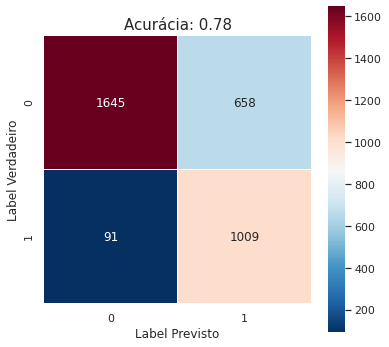

In [26]:
# Criando o modelo

# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

# Selecionando feature target
y = treino['TARGET']

# Transformando target em tipo numerico
y = y.astype("category").cat.codes

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Split dos dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)    


#modelo_xgb_v4 = xgb.XGBClassifier(**study_v2.best_params)
modelo_xgb_v4 = xgb.XGBClassifier(**study_v2.best_params)

# Treinando o modelo
modelo_xgb_v4.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v4.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v4 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v4 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v4), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Bayesian Optimization

In [27]:
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs      = 1,
        objective   = 'binary:logistic',
        eval_metric = 'auc',
        silent      = 1,
        tree_method = 'approx'
    ),
    search_spaces = {
        'learning_rate'    : (0.01, 1.0, 'log-uniform'),
        'min_child_weight' : (0, 10),
        'max_depth'        : (0, 50),
        'max_delta_step'   : (0, 20),
        'subsample'        : (0.01, 1.0, 'uniform'),
        'colsample_bytree' : (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda'       : (1e-9, 1000, 'log-uniform'),
        'reg_alpha'        : (1e-9, 1.0, 'log-uniform'),
        'gamma'            : (1e-9, 0.5, 'log-uniform'),
        'min_child_weight' : (0, 5),
        'n_estimators'     : (50, 100),
        'scale_pos_weight' : (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits     = 4,
        shuffle      = True,
        random_state = 42
    ),
    n_jobs  = 3,
    n_iter  = 20,   
    verbose = 0,
    refit   = True,
    random_state = 42
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [42]:
# Criando o modelo

# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

#X['Original_473_diff'] = X['Original_473'] - X['Original_269']
#X['Original_269_diff'] = X['Original_269'] - X['Original_269'].shift(-1)
#X['Zero_diff']         = X['Zero'] - X['Zero'].shift(-1)
#X['Maca_Verde_diff']   = X['Maca_Verde'] - X['Maca_Verde'].shift(-1)
#X['Tangerina_diff']    = X['Tangerina'] - X['Tangerina'].shift(-1)
#X['Citrus_diff']       = X['Citrus']- X['Citrus'].shift(-1)
#X['Acai_Guarana_diff'] = X['Acai_Guarana'] - X['Acai_Guarana'].shift(-1)
#X['Pessego_diff']      = X['Pessego'] - X['Pessego'].shift(-1)

# Selecionando feature target
y = treino['TARGET']

# Transformando target em tipo numerico
y = y.astype("category").cat.codes

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Split dos dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)

# Treinamento do modelo
result = bayes_cv_tuner.fit(X_treino, y_treino, callback=status_print)

Model #1
Best ROC-AUC: 0.8428
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 0.13031389926541354, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'max_depth': 21, 'min_child_weight': 2, 'n_estimators': 87, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216}

Model #2
Best ROC-AUC: 0.8428
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 0.13031389926541354, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'max_depth': 21, 'min_child_weight': 2, 'n_estimators': 87, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216}

Model #3
Best ROC-AUC: 0.8428
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 0.1303138992654135

In [43]:
result.best_params_

{'colsample_bylevel': 0.8774005648079376,
 'colsample_bytree': 1.0,
 'gamma': 1e-09,
 'learning_rate': 0.5902480198141736,
 'max_delta_step': 18,
 'max_depth': 26,
 'min_child_weight': 3,
 'n_estimators': 81,
 'reg_alpha': 0.00018950180337046291,
 'reg_lambda': 147.8846852660249,
 'scale_pos_weight': 499.99999999999994,
 'subsample': 0.29202555817784076}

Acurácia: 79.05%
Sensibilidade : 1.0
Especificidade : 0.6904038211029092


              precision    recall  f1-score   support

           0       1.00      0.69      0.82      2303
           1       0.61      1.00      0.76      1100

    accuracy                           0.79      3403
   macro avg       0.80      0.85      0.79      3403
weighted avg       0.87      0.79      0.80      3403



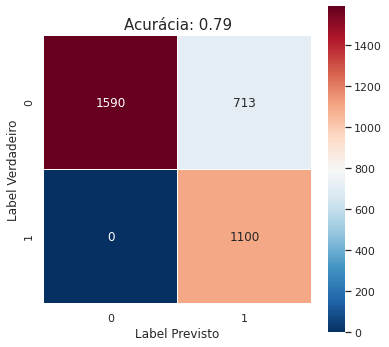

In [44]:
# Criando o modelo com os melhores hyperparametros
modelo_xgb_v5 = xgb.XGBClassifier(**result.best_params_)

# Treinando o modelo
modelo_xgb_v5.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v5.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v5 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v5 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v5), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

# Parte 05. Realizando novas previsões

In [20]:
# Carregando o dataset de testes 
teste  = pd.read_csv(r'to_be_scored.csv')
print('Quantidade de registros e colunas: ',teste.shape)

# Removendo colunas que não serão utilizadas no treinamento
teste = teste.drop(['Tempo','Estação','Movimentação','LAT','LONG'], axis = 1)

# Visualizando os primeiros registros
teste.head()

Quantidade de registros e colunas:  (984, 13)


,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
0,22,65,22,14,3,26,43,18
1,11,56,16,14,43,20,37,15
2,86,51,8,11,41,20,35,12
3,76,47,65,11,37,14,32,10
4,68,42,60,6,35,13,26,5


In [21]:
# Padronizando os dados (0 para a média, 1 para o desvio padrão)
teste_scaler = StandardScaler().fit_transform(teste)

# Realizando previsoes com dados de teste(usando modelo NAO BALANCEADO)
y_pred_test = modelo_xgb_v5.predict(teste_scaler)


In [22]:
# Salvando na coluna target
teste['TARGET'] = y_pred_test
teste['TARGET'] = np.where(teste['TARGET'] == 0, 'NORMAL', 'REABASTECER')

# Visualizando os ultimos registros
teste.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
979,34,65,28,17,33,27,6,2,REABASTECER
980,21,60,18,15,27,22,43,43,NORMAL
981,9,56,13,14,21,17,37,37,REABASTECER
982,86,49,7,14,17,12,33,33,REABASTECER
983,74,41,65,8,14,7,27,27,NORMAL


,TARGET,%
REABASTECER,532,54.065
NORMAL,452,45.935


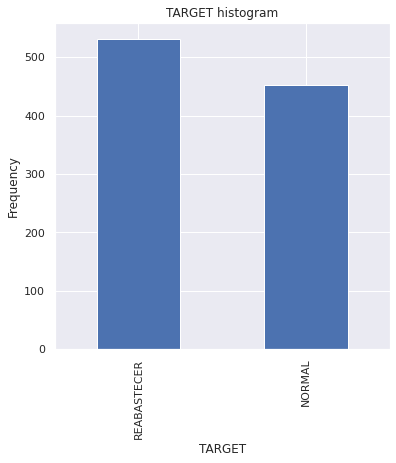

In [23]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(teste['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(teste['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [24]:
# Gravando resultado em csv
teste.to_csv('results_xgb.csv',index=False)